# Определение перспективного тарифа для телеком компании

Формулирование задачи

Компания «Мегалайн», федеральный оператор сотовой связи, предоставила информацию о 500 абонентах, использующих один из двух тарифных планов: «Смарт» и «Ультра». В нашем распоряжении персональные данные клиентов: ФИО, возраст, город, а также информация о том каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Коммерческий департамент планирует скорректировать рекламный бюджет. Для этого необходимо понять, какой тариф приносит больше денег компании. Нам предстоит проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Дополнительно поставлена задача исследовать выручку по клиентам из Москвы и из других регионов, чтобы определить, целесообразно ли разделить рекламный бюджет по географическому признаку.

## Ознакомление с данными

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm
import warnings

from scipy import stats as st
from scipy.stats import mannwhitneyu

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

warnings.filterwarnings('ignore')

Мы импортировали нужные библиотеки и прочитали файлы. Посмотрим на наши данные  

In [3]:
def first_glance(data):
    print('------------------------------------------')
    display(data)
    print('------------------------------------------')
    data.info(memory_usage='deep')
    print('------------------------------------------')
    print('Количество дубликатов в датасете:', data.duplicated().sum())
    print('------------------------------------------')

first_glance(calls)

------------------------------------------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB
------------------------------------------
Количество дубликатов в датасете: 0
------------------------------------------


Датасет **calls** содержит информацию о совершенных пользователями звонках: id операции, id пользователя, дата и длительность звонка в минутах. Всего записей - 202607. Ни один из 4 столбцов не содержит пропусков, дубликаты также отсутствуют.

Столбец `id` содержит уникальный идентификатор звонка пользователя и имеет тип данных object. Мы не планируем использовать данный столбец в наших исследованиях, объем занимаемой памяти не такой уж большой, чтобы оптимизировать ее использование путем изменения типа данных, поэтому оставим данный столбец без изменений.

В столбце `call_date` записаны даты звонков. Вместо строкового типа здель лучше использовать datetime. 

In [4]:
first_glance(messages)

------------------------------------------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB
------------------------------------------
Количество дубликатов в датасете: 0
------------------------------------------


Датасет **messages** содержит данные об отправленных пользователями сообщениях: всего 123036 строки и 3 столбца (id операции, id пользователя и дата отправки сообщения). Пропуски и дубликаты отсутствуют, в типах данных проблема аналогична датасету **calls**.

In [5]:
first_glance(internet)

------------------------------------------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 22.2 MB
------------------------------------------
Количество дубликатов в датасете: 0
------------------------------------------


Датасет **internet** представляет собой статистику использования мобильного интернет-трафика, для каждой записи указаны id операции, id пользователя, количество мегабайт и дата операции. Пропуски и дубликаты отсутствуют, те же проблемы с типами данных, что и в предыдущих случаях.

В дополнение датасет содержит столбец `unnamed: 0`, который дублирует индексы строк и попал в датасет скорее всего в результате технической ошибки при выгрузке. В процессе предобработки данных этот столбец будет удален.

In [6]:
first_glance(users)

------------------------------------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB
------------------------------------------
Количество дубликатов в датасете: 0
------------------------------------------


Датасет **users** содержит информацию о 500 пользователях, попавших в выборку: id пользователя, имя, фамилию, возраст, город, дата регистрации, выбранный тариф и дата прекращения отношений с мобильным оператором. Дубликаты в данных отсутствуют, пропущенные значения имеются только в столбце `churn_date` - NaN'ы указаны для тех пользователей, которые все еще пользуются данным тарифом.

При обработке данных для столбцов с датами мы изменим тип на datetime, а для тарифа - на категориальный. 

In [7]:
first_glance(tariffs)

------------------------------------------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes
------------------------------------------
Количество дубликатов в датасете: 0
------------------------------------------


И последний датасет - **tariffs**. В нем информация о тарифах smart и ultra. Всего 2 строки и 8 столбцов. Проблем с данными не замечено.

---

Для удобства добавим текстовое описание тарифов:

***Тариф «Смарт»***

Ежемесячная плата: 550 рублей.
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.  
Стоимость услуг сверх тарифного пакета:  
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

---

***Тариф «Ультра»***

Ежемесячная плата: 1950 рублей.
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.  
Стоимость услуг сверх тарифного пакета:  
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

---

Итак, мы ознакомились с нашими данными по выборке из 500 пользователей. Для каждого пользователя нам известна персональная информация, тариф, данные о начале и окончании использования тарифа, статистика по звонкам, смс и мобильному интернету.

Проблемы с данными:
1. Users
    - имя и фамилия пользователя указаны в отдельных колонках
    - столбцы с датами имеют строковый тип данных
    - столбец `churn_date` содержит пропуски
    - столбец с тарифами имеет строковый тип - лучше использовать категориальный
2. Calls & messages
    - строковый тип в столбце с датами
3. Internet
    - строковый тип в столбце с датами
    - лишний столбец `unnamed: 0`
    
Обработаем наши таблицы и проверим, нет ли в них артефактов.

## Предобработка данных

Обработаем датасет users: соединим имя и фамилию, приведем даты и тариф в нужные форматы, исследуем пропуски

In [8]:
users['name'] = users['first_name'] + ' ' + users['last_name']
users = users.drop({'first_name', 'last_name'}, axis=1)

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['tariff'] = users['tariff'].astype('category')

first_glance(users)
pd.DataFrame(round((users.isna().mean()*100),2)).style.background_gradient('coolwarm')

------------------------------------------


,user_id,age,churn_date,city,reg_date,tariff,name
0,1000,52,NaT,Краснодар,2018-05-25,ultra,Рафаил Верещагин
1,1001,41,NaT,Москва,2018-11-01,smart,Иван Ежов
2,1002,59,NaT,Стерлитамак,2018-06-17,smart,Евгений Абрамович
3,1003,23,NaT,Москва,2018-08-17,ultra,Белла Белякова
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra,Татьяна Авдеенко
...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,2018-08-28,ultra,Авксентий Фокин
496,1496,36,NaT,Вологда,2018-01-27,smart,Трифон Блохин
497,1497,32,NaT,Челябинск,2018-10-09,smart,Каролина Агеева
498,1498,68,2018-10-25,Владикавказ,2018-07-19,smart,Всеволод Акимчин


------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   reg_date    500 non-null    datetime64[ns]
 5   tariff      500 non-null    category      
 6   name        500 non-null    object        
dtypes: category(1), datetime64[ns](2), int64(2), object(2)
memory usage: 127.7 KB
------------------------------------------
Количество дубликатов в датасете: 0
------------------------------------------


,0
user_id,0.000000
age,0.000000
churn_date,92.400000
city,0.000000
reg_date,0.000000
tariff,0.000000
name,0.000000


Мы обработали датафрейм **users**: объединили в одной колонке имя и фамилию пользователя, изменили тип данных для дат и тарифов. 

Посмотрим, можем ли мы что-то сделать с пропущенными значениями в столбце `churn_date` - их почти 93%. Пропуск в данном столбце явно означает, что пользователь продолжает сотрудничество с компанией. Создадим отдельный столбец, в котором обозначим, является ли пользователь активным (действующим на момент выгрузки данных).

In [9]:
users['is_active'] = users['churn_date'].fillna(1)
users['is_active'] = users['is_active'].where(users['is_active'] == 1, 0).astype(int)
users.groupby('tariff')['is_active'].mean()

tariff
smart    0.934473
ultra    0.899329
Name: is_active, dtype: float64

Цифрой 1 мы обозначили пользователей, которые на дату выгрузки еще пользовались своим тарифом, а цифрой 0 - тех, кто ушел. Посчитали среднее значение для каждого тарифа - цифры незначительно, но различаются. Данная информация может пригодиться, если мы запланируем провести более глубокий анализ оттока клиентов с разных тарифов. Данные о дате расторжения договора важны для нашего исследования, пропуски в данных пока не создают помех для анализа, поэтому было принято решение не избавляться от пропущенных значений в столбце `churn_date`.

Подготовим к работе датафреймы со статистикой пользователей: calls, messages, internet. Они все имеют схожие проблемы в данных, поэтому удобнее обработать их, применив функцию. 

In [10]:
def pre_processing(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')
    data['month'] = data[column].dt.month
    return data

calls = pre_processing(calls, 'call_date')

calls['duration'].describe()
calls[calls['duration'] == 0]['id'].count() / len(calls)
calls.info()
calls

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

0.19551644316336553

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


В нашем датасете 1/5 звонков имеет продолжительность 0.0 минут. Скорее всего, это пропущенные вызовы. Они не тарифицируются оператором, поэтому на размер выручки с каждого клиента такие звонки не повлияют. Но в рамках нашего исследования нам предстоит проанализировать среднюю длительность звонков. Наличие в датасете неуспешных звонков длительностью 0 минут повлияет на расчет среднего значения продолжительности разговора, сместив его в сторону меньших значений. Это приведет к искажению результатов, поэтому мы приняли решение удалить звонки с нулевой длительностью. 

Нам известно, что длительность разговора оператор округляет в большую сторону. Округлим значения в столбце duration до целых значений (в сторону большего ближайшего целого значения).

In [11]:
calls = calls.drop(np.where(calls['duration'] == 0)[0])
calls[calls['duration'] == 0]['id'].count()
calls['duration'] = calls['duration'].apply(np.ceil)
calls

0

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


Пропущенные вызовы успешно удалены, минуты разговора округлены до большего целого значения. 

Сгруппируем таблицу по пользователю и месяцу и посчитаем общее количество звонков и длительность разговоров помесячно для каждого пользователя

In [12]:
calls_stat = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).reset_index()
calls_stat.columns = ['user_id', 'month', 'calls', 'minutes']
calls_stat

,user_id,month,calls,minutes
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0
...,...,...,...,...
3163,1498,10,30,247.0
3164,1499,9,8,70.0
3165,1499,10,44,449.0
3166,1499,11,62,612.0


Аналогичные преобразования произведем для датасета с смс

In [13]:
messages = pre_processing(messages, 'message_date')
messages

messages_stat = messages.groupby(['user_id', 'month'])[['id']].count().reset_index()
messages_stat.columns = ['user_id', 'month', 'messages']
messages_stat

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Подготовим данные по использованию мобильного интернета: приведем к нужному типу, добавим месяц, удалим лишний столбец. Чтобы увидеть аномалии в данных, запросим описательную статистику

In [14]:
internet = pre_processing(internet, 'session_date')
internet = internet.drop('Unnamed: 0', axis=1)

internet['mb_used'].describe()
internet[internet['mb_used'] == 0]['id'].count() / len(internet)
internet.info()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

0.13118155773916304

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Ситуация с доступом в сеть похожа на ситуацию со звонками: минимальное значение количества использованного трафика - 0 МБ. Таких сессий у нас 13%. Вероятно, это неуспешные попытки входа в интернет. Удалим их из датафрейма аналогично пропущенным звонкам, оставшиеся значения округлим в большую сторону по правилам оператора.

In [15]:
internet.head()
internet = internet.drop(np.where(internet['mb_used'] == 0)[0])
internet[internet['mb_used'] == 0]['id'].count()
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


0

,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


Таблица с данными по мобильному интернету готова к использованию. Выведем статистику по месяцам в разрезе абонентов

In [16]:
internet_stat = internet.groupby(['user_id', 'month'])[['mb_used']].sum().reset_index()
internet_stat.columns = ['user_id', 'month', 'mbs']
internet_stat

,user_id,month,mbs
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3196,1498,10,20604.0
3197,1499,9,1848.0
3198,1499,10,17809.0
3199,1499,11,17984.0


Итак, мы подготовили наши данные. Чтобы иметь перед глазами общую картину активности клиентов, сольем информацию о звонках, смс и трафике в единую таблицу **stat**

In [17]:
stat = calls_stat.merge(messages_stat, on=['user_id', 'month'], how='outer')
stat = stat.merge(internet_stat, on=['user_id', 'month'], how='outer')
stat.head(15)

,user_id,month,calls,minutes,messages,mbs
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0
5,1000,10,44.0,350.0,73.0,14717.0
6,1000,11,37.0,338.0,58.0,14768.0
7,1000,12,38.0,333.0,70.0,9827.0
8,1001,11,45.0,430.0,NaN,18452.0
9,1001,12,47.0,414.0,NaN,14053.0


Создадим таблицу с тарифами и бесплатными минутами/смс/мб для каждого пользователя

In [18]:
user_tariff = users[['user_id', 'tariff']]
user_tariff 
free = tariffs[['tariff_name', 'minutes_included', 'messages_included', 'mb_per_month_included']]
free.columns = ['tariff', 'free_mins', 'free_sms', 'free_mbs']
free
user_tariff = user_tariff.merge(free, on='tariff', how='left')
user_tariff

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra
...,...,...
495,1495,ultra
496,1496,smart
497,1497,smart
498,1498,smart


,tariff,free_mins,free_sms,free_mbs
0,smart,500,50,15360
1,ultra,3000,1000,30720


,user_id,tariff,free_mins,free_sms,free_mbs
0,1000,ultra,3000,1000,30720
1,1001,smart,500,50,15360
2,1002,smart,500,50,15360
3,1003,ultra,3000,1000,30720
4,1004,ultra,3000,1000,30720
...,...,...,...,...,...
495,1495,ultra,3000,1000,30720
496,1496,smart,500,50,15360
497,1497,smart,500,50,15360
498,1498,smart,500,50,15360


Присоединим нашу таблицу **user_tariff** к таблице со статистикой **stat**. Проверим на наличие пропусков и, если они есть, обработаем их.

In [19]:
stat = stat.merge(user_tariff, on='user_id', how='outer')
stat
pd.DataFrame(round((stat.isna().mean()*100),2)).style.background_gradient('coolwarm')
stat[['calls', 'minutes', 'messages', 'mbs']] = stat[['calls', 'minutes', 'messages', 'mbs']].fillna(0)
pd.DataFrame(round((stat.isna().mean()*100),2)).style.background_gradient('coolwarm')  

,user_id,month,calls,minutes,messages,mbs,tariff,free_mins,free_sms,free_mbs
0,1000,5.0,17.0,159.0,22.0,2256.0,ultra,3000,1000,30720
1,1000,6.0,28.0,172.0,60.0,23257.0,ultra,3000,1000,30720
2,1000,7.0,41.0,340.0,75.0,14016.0,ultra,3000,1000,30720
3,1000,8.0,42.0,408.0,81.0,14070.0,ultra,3000,1000,30720
4,1000,9.0,46.0,466.0,57.0,14581.0,ultra,3000,1000,30720
...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19588.0,smart,500,50,15360
3212,1489,11.0,NaN,NaN,20.0,17516.0,smart,500,50,15360
3213,1489,12.0,NaN,NaN,35.0,17341.0,smart,500,50,15360
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,3000,1000,30720


,0
user_id,0.000000
month,0.060000
calls,1.490000
minutes,1.490000
messages,15.520000
mbs,0.470000
tariff,0.000000
free_mins,0.000000
free_sms,0.000000
free_mbs,0.000000


,0
user_id,0.000000
month,0.060000
calls,0.000000
minutes,0.000000
messages,0.000000
mbs,0.000000
tariff,0.000000
free_mins,0.000000
free_sms,0.000000
free_mbs,0.000000


Мы приняли решение не удалять пропуски в количестве звонков, минут, смс и мегабайт, а заменить их на 0. В эти месяцы клиенты не пользовались определенными типами услуг - данная информация важна для анализа активности клиентов по месяцам. Пропуски в колонке с месяцем составляют менее одного процента. Пока оставим их без изменений. 

Мы завершили предварительную обработку данных. Теперь для каждого пользователя нам инвестно: используемый тариф, количество бесплатных минут, сообщений и трафика, и фактически потраченные минуты/смс/мегабайты. Посчитаем, кто из пользователей превысил предусмотренный тарифом бесплатный лимит, и сколько при этом заплатил из собственных средств

## Расчеты

Платные услуги - это разница между фактически использованным клиентом объемом и количеством включенных в абонентскую плату минут/смс/мегабайт. Для тех абонентов, кто не превысил лимит, в соответствующей ячейке ставим ноль

In [20]:
stat['paid_mins'] = (stat['minutes'] - stat['free_mins']).where((stat['minutes'] - stat['free_mins']) >= 0, 0)
stat['paid_sms'] = (stat['messages'] - stat['free_sms']).where((stat['messages'] - stat['free_sms']) >= 0, 0)
stat['paid_mbs'] = (stat['mbs'] - stat['free_mbs']).where((stat['mbs'] - stat['free_mbs']) >= 0, 0)

stat.sample(10)

,user_id,month,calls,minutes,messages,mbs,tariff,free_mins,free_sms,free_mbs,paid_mins,paid_sms,paid_mbs
982,1157,7.0,54.0,491.0,0.0,18929.0,smart,500,50,15360,0.0,0.0,3569.0
2692,1424,7.0,1.0,12.0,111.0,32788.0,ultra,3000,1000,30720,0.0,0.0,2068.0
703,1113,8.0,77.0,654.0,42.0,11244.0,smart,500,50,15360,154.0,0.0,0.0
2874,1453,11.0,100.0,973.0,57.0,24069.0,ultra,3000,1000,30720,0.0,0.0,0.0
1389,1220,11.0,24.0,236.0,0.0,6468.0,smart,500,50,15360,0.0,0.0,0.0
895,1145,6.0,50.0,397.0,99.0,13006.0,smart,500,50,15360,0.0,49.0,0.0
2154,1344,6.0,92.0,825.0,119.0,22361.0,ultra,3000,1000,30720,0.0,0.0,0.0
773,1123,5.0,59.0,546.0,21.0,22976.0,smart,500,50,15360,46.0,0.0,7616.0
1355,1215,10.0,44.0,329.0,16.0,14219.0,smart,500,50,15360,0.0,0.0,0.0
319,1051,9.0,44.0,311.0,6.0,14307.0,smart,500,50,15360,0.0,0.0,0.0


Теперь мы знаем количество платных услуг. Сверимся еще раз с условиями тарифов

In [21]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


... и переведем платные услуги в деньги.
Расчитаем месячный доход с одного клиента. Для этого создадим датафрейм **revenue** и добавим в него цены из датафрейма **tariffs**. 

В тарифах у нас указана плата за гигабайт, а в статистике - количество использованных мегабайт трафика. Нам известно, что оператор округляет значение минут и мегабайт в большую сторону - учтем это в расчетах.

In [22]:
revenue = stat[['user_id', 'month', 'tariff', 'paid_mins', 'paid_sms', 'paid_mbs']]
prices = tariffs[['tariff_name', 'rub_monthly_fee', 'rub_per_minute', 'rub_per_message', 'rub_per_gb']]
prices.columns = ['tariff', 'rub_monthly_fee', 'rub_per_min', 'rub_per_sms', 'rub_per_gb']
prices
revenue = revenue.merge(prices, on='tariff', how='left')

users_temp = users.drop(['tariff'], axis='columns')
revenue = revenue.merge(users_temp, on='user_id', how='outer')

revenue['paid_gbs'] = (revenue['paid_mbs'] / 1024).apply(np.ceil)
revenue

,tariff,rub_monthly_fee,rub_per_min,rub_per_sms,rub_per_gb
0,smart,550,3,3,200
1,ultra,1950,1,1,150


,user_id,month,tariff,paid_mins,paid_sms,paid_mbs,rub_monthly_fee,rub_per_min,rub_per_sms,rub_per_gb,age,churn_date,city,reg_date,name,is_active,paid_gbs
0,1000,5.0,ultra,0.0,0.0,0.0,1950,1,1,150,52,NaT,Краснодар,2018-05-25,Рафаил Верещагин,1,0.0
1,1000,6.0,ultra,0.0,0.0,0.0,1950,1,1,150,52,NaT,Краснодар,2018-05-25,Рафаил Верещагин,1,0.0
2,1000,7.0,ultra,0.0,0.0,0.0,1950,1,1,150,52,NaT,Краснодар,2018-05-25,Рафаил Верещагин,1,0.0
3,1000,8.0,ultra,0.0,0.0,0.0,1950,1,1,150,52,NaT,Краснодар,2018-05-25,Рафаил Верещагин,1,0.0
4,1000,9.0,ultra,0.0,0.0,0.0,1950,1,1,150,52,NaT,Краснодар,2018-05-25,Рафаил Верещагин,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,smart,0.0,0.0,4228.0,550,3,3,200,35,NaT,Санкт-Петербург,2018-08-15,Павел Гончаров,1,5.0
3212,1489,11.0,smart,0.0,0.0,2156.0,550,3,3,200,35,NaT,Санкт-Петербург,2018-08-15,Павел Гончаров,1,3.0
3213,1489,12.0,smart,0.0,0.0,1981.0,550,3,3,200,35,NaT,Санкт-Петербург,2018-08-15,Павел Гончаров,1,2.0
3214,1128,NaN,ultra,0.0,0.0,0.0,1950,1,1,150,51,2018-12-23,Волжский,2018-12-15,Ксения Агаева,0,0.0


Теперь мы владеем более полной информацией о каждом клиенте. Вернемся к тем нескольким клиентам, у которых не указан месяц оказания услуги.

In [23]:
no_month = revenue.loc[revenue['month'].isna()]
no_month

,user_id,month,tariff,paid_mins,paid_sms,paid_mbs,rub_monthly_fee,rub_per_min,rub_per_sms,rub_per_gb,age,churn_date,city,reg_date,name,is_active,paid_gbs
3214,1128,NaN,ultra,0.0,0.0,0.0,1950,1,1,150,51,2018-12-23,Волжский,2018-12-15,Ксения Агаева,0,0.0
3215,1371,NaN,smart,0.0,0.0,0.0,550,3,3,200,50,2018-12-30,Омск,2018-12-25,Ириней Трофимов,0,0.0


Ага. Пришли в декабре и через несколько дней расторгли договор или сменили тариф. Всего два человека. Вероятно месяц не определился, так как в исходных датасетах отсутствовалат информация о совершенных этими клиентами операциях - соответственно оператор спишет с них только абонентскую плату. Можно было бы пренебречь этими 2 строками, но мы не станем этого делать, так как нам легко заполнить пропуски для них - поставим в значении месяца цифру 12 (декабрь).

In [24]:
revenue['month'] = revenue['month'].fillna(12)
revenue['month'].isna().sum()

0

Готово, пропусков больше нет. Расчитаем выручку компании по каждому клиенту. Для этого умножим количество платных минут/смс/гигабайт на соответствующую цену и просуммируем, добавим также ежемесячную абонентскую плату.

In [25]:
revenue['total_rev'] = (
    revenue['rub_monthly_fee'] + 
    revenue['paid_mins'] * revenue['rub_per_min'] + 
    revenue['paid_sms'] * revenue['rub_per_sms'] +
    revenue['paid_gbs'] * revenue['rub_per_gb']
)

revenue.sample(10)

print('Общая выручка:', int(revenue['total_rev'].sum()))
print('Абонентская плата:', revenue['rub_monthly_fee'].sum())
print('Услуги сверх абоненской платы:', int(revenue['total_rev'].sum()) - revenue['rub_monthly_fee'].sum())

,user_id,month,tariff,paid_mins,paid_sms,paid_mbs,rub_monthly_fee,rub_per_min,rub_per_sms,rub_per_gb,age,churn_date,city,reg_date,name,is_active,paid_gbs,total_rev
289,1046,10.0,smart,0.0,0.0,9141.0,550,3,3,200,72,NaT,Тула,2018-08-20,Екатерина Александрова,1,9.0,2350.0
2625,1414,5.0,smart,0.0,0.0,6093.0,550,3,3,200,70,NaT,Владимир,2018-05-05,Александра Лобанова,1,6.0,1750.0
781,1124,9.0,ultra,0.0,0.0,0.0,1950,1,1,150,54,NaT,Махачкала,2018-09-24,Альбин Андрианов,1,0.0,1950.0
384,1061,7.0,smart,0.0,0.0,0.0,550,3,3,200,41,NaT,Санкт-Петербург,2018-07-15,Тамара Ситникова,1,0.0,550.0
434,1067,10.0,smart,0.0,14.0,0.0,550,3,3,200,45,NaT,Москва,2018-04-09,Юзефа Абашкина,1,0.0,592.0
2021,1323,9.0,smart,0.0,10.0,7522.0,550,3,3,200,67,NaT,Челябинск,2018-08-02,Эсмеральда Носкова,1,8.0,2180.0
3003,1471,11.0,ultra,0.0,0.0,0.0,1950,1,1,150,35,NaT,Вологда,2018-02-26,Элеонора Гаврилова,1,0.0,1950.0
3030,1475,12.0,smart,0.0,0.0,981.0,550,3,3,200,40,NaT,Новокузнецк,2018-01-09,Лидия Фадеева,1,1.0,750.0
1319,1208,12.0,ultra,0.0,0.0,0.0,1950,1,1,150,69,NaT,Пермь,2018-03-24,Ева Сахарова,1,0.0,1950.0
558,1089,4.0,ultra,0.0,0.0,0.0,1950,1,1,150,19,NaT,Иркутск,2018-02-24,Ксения Нечаева,1,0.0,1950.0


Общая выручка: 4928251
Абонентская плата: 3149200
Услуги сверх абоненской платы: 1779051


Итак, нам теперь известно значение месячного дохода, который компания получает с каждого клиента. Всего за 2018 год с 500 клиентов оператор заработал 4.8 млн рублей, из которых 3.1 млн - абонентская плата, а 1.7 млн - платные услуги сверх лимита.

В наши датасеты calls, messages и internet попадала информация о фактически оказанных клиенту услугах. При этом данных о факте списания с клиента абонентской платы в нашем распоряжении нет (мы добавили эти цифры самостоятельно исходя из используемого клиентом тарифа). Как правило, абонентская плата списывается с клиента независимо от того, производил ли он\она какие-либо активности в текущем месяце. Соответственно, существует риск того, что в наших финальных расчетах мы могли не учесть абонентскую плату за те месяцы, в которые клиенты не проявляли активность в части звонков, сообщений и мобильного интернета.

Проверим корректность наших расчетов, используя период активности клиентов. В качестве количества активных месяцев, за которые оператор списал абоненскую плату, примем разницу между первым месяцем (месяц регистрации клиента / перехода на тариф) и последним месяцем (месяц расторжения договора / смены тарифа или последний месяц года, если клиент еще активен) + 1 месяц (так как плата взимается как за первый, так и за последний месяц).

Количество месяцев активности умножим на размер абонентской платы и суммируем по всем клиентам.

In [26]:
activity_summary = revenue[['user_id', 'tariff', 'rub_monthly_fee', 'churn_date', 'reg_date', 'is_active']]
activity_summary['last_month'] = activity_summary['churn_date'].dt.month.fillna(12)
activity_summary['first_month'] = activity_summary['reg_date'].dt.month
activity_summary['n_act_months'] = activity_summary['last_month'] - activity_summary['first_month'] + 1

activity_summary = activity_summary.drop_duplicates()
activity_summary['total_fee'] = activity_summary['rub_monthly_fee'] * activity_summary['n_act_months']
activity_summary['total_fee'].sum()
activity_summary

3149200.0

,user_id,tariff,rub_monthly_fee,churn_date,reg_date,is_active,last_month,first_month,n_act_months,total_fee
0,1000,ultra,1950,NaT,2018-05-25,1,12.0,5,8.0,15600.0
8,1001,smart,550,NaT,2018-11-01,1,12.0,11,2.0,1100.0
10,1002,smart,550,NaT,2018-06-17,1,12.0,6,7.0,3850.0
17,1003,ultra,1950,NaT,2018-08-17,1,12.0,8,5.0,9750.0
22,1004,ultra,1950,NaT,2018-05-14,1,12.0,5,8.0,15600.0
...,...,...,...,...,...,...,...,...,...,...
3201,1328,ultra,1950,NaT,2018-10-16,1,12.0,10,3.0,5850.0
3204,1473,ultra,1950,NaT,2018-08-05,1,12.0,8,5.0,9750.0
3209,1489,smart,550,NaT,2018-08-15,1,12.0,8,5.0,2750.0
3214,1128,ultra,1950,2018-12-23,2018-12-15,0,12.0,12,1.0,1950.0


Итак, итоговая сумма выручки, полученной компанией с клиентов из выборки по статье "абонентская плата" расчитана двумя способами. Цифры полностью совпадают, значит, мы ничего не упустили, и расчеты выполнены корректно.

## Анализ поведения пользователя 

Давайте посмотрим, как ведут себя клиенты двух тарифов: сколько минут тратят на звонки, сколько сообщений отправляют и какое количество интернет-трафика используют ежемесячно. Разделим клиентов на 2 группы в зависимости от тарифа и посмотрим на статистику по месяцам 

In [27]:
smart_stat = stat.loc[stat['tariff'] == 'smart']
ultra_stat = stat.loc[stat['tariff'] == 'ultra']

grouped_smart_stat = smart_stat.groupby('month')[['minutes', 'messages', 'mbs']].mean()
grouped_smart_stat
grouped_ultra_stat = ultra_stat.groupby('month')[['minutes', 'messages', 'mbs']].mean()
grouped_ultra_stat

,minutes,messages,mbs
month,,,
1.0,203.852941,18.235294,8524.441176
2.0,298.689655,24.086207,11611.396552
3.0,390.051948,31.857143,15123.857143
4.0,367.133929,30.741071,13479.482143
5.0,387.361702,33.773050,15825.198582
6.0,395.640244,33.402439,15814.768293
7.0,408.353234,33.751244,15763.512438
8.0,421.468085,33.638298,16632.174468
9.0,428.611538,33.638462,16324.526923


,minutes,messages,mbs
month,,,
1.0,428.111111,33.777778,13153.555556
2.0,297.125000,21.958333,11786.958333
3.0,489.648649,32.297297,17551.972973
4.0,458.018182,31.563636,16843.800000
5.0,510.328358,37.850746,19381.194030
6.0,479.702381,41.726190,18942.238095
7.0,545.791209,49.846154,20514.648352
8.0,510.775701,48.439252,19594.065421
9.0,539.443478,52.286957,19222.208696


От месяца к месяцу данные разнятся. Используем для визуализации линейные графики

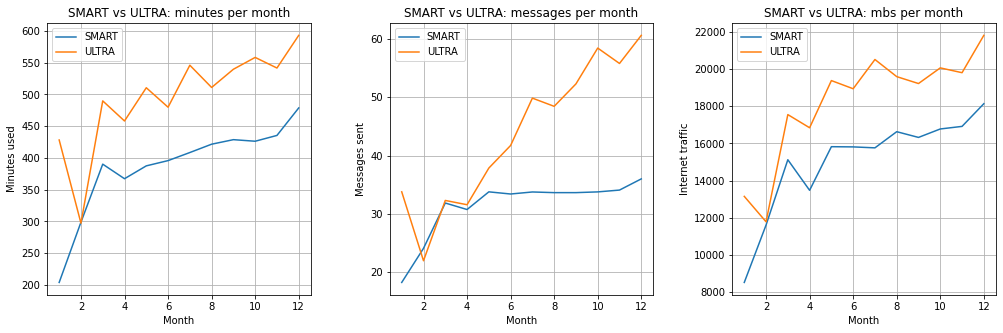

In [28]:
fig, axes = plt.subplots(ncols = 3, figsize=(17, 5))
axes[0].set_title('SMART vs ULTRA: minutes per month')
axes[0].plot(grouped_smart_stat['minutes'])
axes[0].plot(grouped_ultra_stat['minutes'])
axes[0].grid()
axes[0].set_ylabel('Minutes used')
axes[0].set_xlabel('Month')
axes[0].legend(labels=['SMART', 'ULTRA'])

axes[1].set_title('SMART vs ULTRA: messages per month')
axes[1].plot(grouped_smart_stat['messages'])
axes[1].plot(grouped_ultra_stat['messages'])
axes[1].grid()
axes[1].set_ylabel('Messages sent')
axes[1].set_xlabel('Month')
axes[1].legend(labels=['SMART', 'ULTRA'])

axes[2].set_title('SMART vs ULTRA: mbs per month')
axes[2].plot(grouped_smart_stat['mbs'])
axes[2].plot(grouped_ultra_stat['mbs'])
axes[2].grid()
axes[2].set_ylabel('Internet traffic')
axes[2].set_xlabel('Month')
axes[2].legend(labels=['SMART', 'ULTRA'])
plt.subplots_adjust(wspace=0.3, hspace=0.5);

In [29]:
users['reg_date'].min()
users['reg_date'].max()
tariffs

Timestamp('2018-01-01 00:00:00')

Timestamp('2018-12-31 00:00:00')

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


На графиках видна динамика использования клиентами минут, смс и трафика по месяцам: синяя линия для тарифа SMART и оранжевая - для ULTRA. 

Для всех трех "продуктов" в обоих тарифах видна тенденция к увеличению потребления к концу года, с максимальным объемом в декабре. В это время люди готовятся к большим новогодним и рождественским праздникам, поздравляют друг друга, обсуждают планы на каникулы, чаще заходят в интернет для поиска подарков и заказа услуг, многие организации также работают более интенсивно, чтобы успеть закончить дела до праздников - поэтому повышенная активность пользователей в декабре вполне объяснима.

Мы знаем, что в нашу выборку включены пользователи, чья дата заключения договора попала в промежуток между 01.01.2018 и 31.12.2018 - вполне логично на этом фоне выглядит положительная динамика объема потребляемых услуг в зависимости от месяца: пользователи, пришедшие в начале года, осваиваются и становятся более лояльными к компании, и каждый месяц добавляются новые пользователи, увеличивающие суммарное потребление услуг компании.

Вызывает интерес поведение графиков в феврале - мы видим что суммарные средние объемы потребления минут, смс и мегабайт в этом месяце для обоих тарифов сближаются, и если для SMART характерна устойчивая положительная динамика, то у ULTRA существенное проседание в объеме потребления услуг.   
Что же могло повлиять на столь драматическое падение объема у пользователей тарифа ULTRA?
В период с 9 по 25 февраля 2018 года в Корее проходили зимние олимпийские игры. Может, все были так прикованы к экранам телевизора, что времени на смартфон совсем не оставалось?

К сожалению, в нашей выборке недостаточно информации для формулирования полноценных выводов о наличии сезонных тенденций. Если мы запланируем такое исследование, необходимо будет включить в выборку данные за несколько лет.

В целом для тарифа ULTRA характерен больший объем используемых услуг - этот тариф иначально предназначен для клиентов с бОльшими потребностями: пакет бесплатных минут в нем больше в 6 раз, смс - в 20 раз, а трафика - в 2 раза. 

Посмотрим как распределено среднее количество звонков, сообщений и трафика. Для этого построим гистограммы для каждого из тарифов

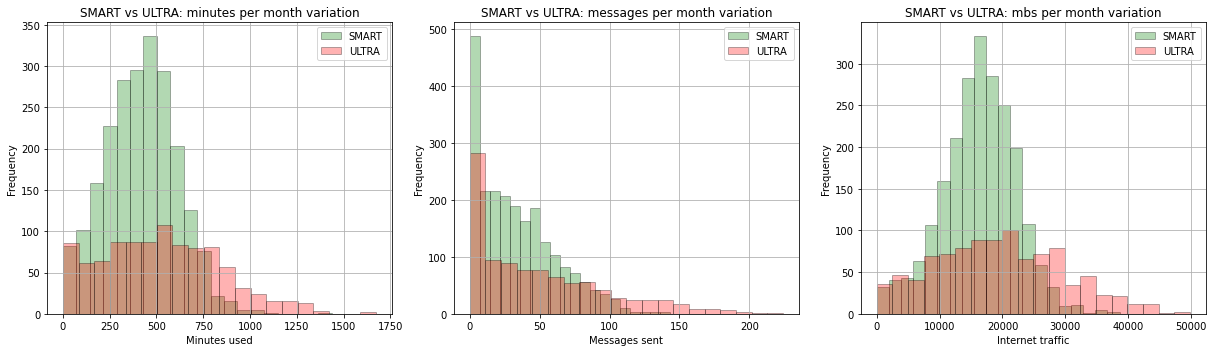

In [30]:
fig, axes = plt.subplots(ncols = 3, figsize=(17, 5))
axes[0].set_title('SMART vs ULTRA: minutes per month variation')
axes[0].hist(smart_stat['minutes'], bins=20, alpha=0.3, ec='black', color='green')
axes[0].hist(ultra_stat['minutes'], bins=20, alpha=0.3, ec='black', color='red')
axes[0].grid()
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Minutes used')
axes[0].legend(labels=['SMART', 'ULTRA'])

axes[1].set_title('SMART vs ULTRA: messages per month variation')
axes[1].hist(smart_stat['messages'], bins=20, alpha=0.3, ec='black', color='green')
axes[1].hist(ultra_stat['messages'], bins=20, alpha=0.3, ec='black', color='red')
axes[1].grid()
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Messages sent')
axes[1].legend(labels=['SMART', 'ULTRA'])

axes[2].set_title('SMART vs ULTRA: mbs per month variation')
axes[2].hist(smart_stat['mbs'], bins=20, alpha=0.3, ec='black', color='green')
axes[2].hist(ultra_stat['mbs'], bins=20, alpha=0.3, ec='black', color='red')
axes[2].grid()
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Internet traffic')
axes[2].legend(labels=['SMART', 'ULTRA'])
fig.tight_layout();

Дополним визуальные данные описательной статистикой - это поможет нам сделать корректные выводы

In [31]:
smart_stat.describe()

,user_id,month,calls,minutes,messages,mbs,free_mins,free_sms,free_mbs,paid_mins,paid_sms,paid_mbs
count,2230.000000,2229.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.0,2230.0,2230.0,2230.000000,2230.000000,2230.000000
mean,1246.562332,8.346792,46.926457,417.747534,33.369058,16221.910762,500.0,50.0,15360.0,41.586996,5.797309,2769.357399
std,146.110501,2.920316,21.057932,190.476754,28.230396,5886.299627,0.0,0.0,0.0,84.664160,13.440001,3604.041249
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,500.0,50.0,15360.0,0.000000,0.000000,0.000000
25%,1121.000000,6.000000,32.000000,282.000000,10.000000,12645.250000,500.0,50.0,15360.0,0.000000,0.000000,0.000000
50%,1240.000000,9.000000,47.000000,421.500000,28.000000,16529.000000,500.0,50.0,15360.0,0.000000,0.000000,1169.000000
75%,1376.000000,11.000000,61.000000,545.000000,51.000000,20068.000000,500.0,50.0,15360.0,45.000000,1.000000,4708.000000
max,1499.000000,12.000000,162.000000,1435.000000,143.000000,38610.000000,500.0,50.0,15360.0,935.000000,93.000000,23250.000000


In [32]:
ultra_stat.describe()

,user_id,month,calls,minutes,messages,mbs,free_mins,free_sms,free_mbs,paid_mins,paid_sms,paid_mbs
count,986.000000,985.000000,986.000000,986.000000,986.000000,986.000000,986.0,986.0,986.0,986.0,986.0,986.000000
mean,1262.957404,8.250761,59.176471,526.089249,49.313387,19467.137931,3000.0,1000.0,30720.0,0.0,0.0,753.786004
std,140.689268,2.871762,35.594691,317.887549,47.806040,10110.255401,0.0,0.0,0.0,0.0,0.0,2431.259510
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3000.0,1000.0,30720.0,0.0,0.0,0.000000
25%,1143.000000,6.000000,33.000000,282.500000,6.000000,11761.000000,3000.0,1000.0,30720.0,0.0,0.0,0.000000
50%,1277.000000,9.000000,58.000000,518.000000,38.000000,19320.000000,3000.0,1000.0,30720.0,0.0,0.0,0.000000
75%,1381.000000,11.000000,83.750000,751.750000,78.750000,26860.250000,3000.0,1000.0,30720.0,0.0,0.0,0.000000
max,1495.000000,12.000000,190.000000,1673.000000,224.000000,49789.000000,3000.0,1000.0,30720.0,0.0,0.0,19069.000000


На гистограммах выше изображено распределение длительности разговора, количества отправленных смс и использованного интернет-трафика для тарифов SMART (зеленая заливка) и ULTRA (красная заливка). 

Мы видим, что для пользователей ULTRA характерно более пологое распределение - значит данные значительно отклоняются от среднего значения. О большом разбросе значений в тарифе ULTRA свидетельствует также и большое значение стандартного отклонения выборки - для минут и смс оно очень близко к значению среднего. В то же время значение стандартного отклонения для объема услуг тарифа SMART для минут составляет менее половины значения среднего, а для интернета - всего 1/3. Гистограммы это подтверждают - зеленые столбики стоят кучно вокруг среднего, тогда как красные широко распластались.

На гистограмме для сообщений отчетливо видно, что мода распределения находится близко к отметке 0 для обоих тарифов - это наиболее часто встречающееся значение. Похоже, что дни смс'ок сочтены - им на смену пришли мессенджеры. Хотя некоторые пользователи тарифа ULTRA все еще отправляют больше 100 сообщений в месяц - это и неудивительно, ведь в абонентскую плату включены 1000 смс!

Если посмотреть на максимальные значения объема используемых услуг, то для тарифа ULTRA их частота выше, чем для SMART. Абонентская плата больше, лимиты выше - можно смело пользоваться, раз оплачено.

Для большей наглядности посчитаем для каждого тарифа значения среднего, дисперсии и стандартного отклонения (в целом для услуг и отдельно для платных услуг)

In [33]:
stat.groupby('tariff')[['minutes', 'messages', 'mbs']].agg(['mean', 'var', 'std']).round(0)
stat.groupby('tariff')[['paid_mins', 'paid_sms', 'paid_mbs']].agg(['mean', 'var', 'std']).round(0)

minutes                  messages                    mbs               \
          mean       var    std     mean     var   std     mean          var   
tariff                                                                         
smart    418.0   36281.0  190.0     33.0   797.0  28.0  16222.0   34648523.0   
ultra    526.0  101052.0  318.0     49.0  2285.0  48.0  19467.0  102217264.0   

                 
            std  
tariff           
smart    5886.0  
ultra   10110.0

paid_mins               paid_sms              paid_mbs              \
            mean     var   std     mean    var   std     mean         var   
tariff                                                                      
smart       42.0  7168.0  85.0      6.0  181.0  13.0   2769.0  12989113.0   
ultra        0.0     0.0   0.0      0.0    0.0   0.0    754.0   5911023.0   

                
           std  
tariff          
smart   3604.0  
ultra   2431.0

В среднем пользователь на тарифе SMART наговаривает в месяц 418 минут, отправляет 33 сообщения и использует 17 гб трафика. Из них доплачивает сверх бесплатного лимита за 42 минуты, 6 сообщений и 3 гб интернета.

В то же время средний ULTRA-пользователь в месяц говорит 526 минут, отправляет 49 сообщений и использует 20 гб трафика. Из них платные услуги: 0 минут, 0 смс и 1 гб интернета. Получается, что на тарифе ULTRA пользователь по звонкам и смс полностью "укладывается" в бесплатный пакет, доплачивает только за сверхлимитный интернет.

Исследуем подробно эпизоды, когда пользователь выходит за бесплатный лимит

In [34]:
grouped_smart_stat_users = smart_stat.groupby('user_id')[['paid_mins', 'paid_sms', 'paid_mbs']].sum()
grouped_smart_stat_users
len(grouped_smart_stat_users.query('(paid_mins + paid_sms + paid_mbs) != 0')) / len(grouped_smart_stat_users)

grouped_ultra_stat_users = ultra_stat.groupby('user_id')[['paid_mins', 'paid_sms', 'paid_mbs']].sum()
grouped_ultra_stat_users
len(grouped_ultra_stat_users.query('(paid_mins + paid_sms + paid_mbs) != 0')) / len(grouped_ultra_stat_users)

,paid_mins,paid_sms,paid_mbs
user_id,,,
1001,0.0,0.0,3092.0
1002,0.0,0.0,14607.0
1005,1075.0,33.0,0.0
1006,0.0,0.0,18239.0
1007,357.0,0.0,9061.0
...,...,...,...
1494,1.0,0.0,9061.0
1496,516.0,1.0,98543.0
1497,45.0,0.0,4580.0


0.9487179487179487

,paid_mins,paid_sms,paid_mbs
user_id,,,
1000,0.0,0.0,0.0
1003,0.0,0.0,0.0
1004,0.0,0.0,0.0
1013,0.0,0.0,0.0
1016,0.0,0.0,0.0
...,...,...,...
1476,0.0,0.0,0.0
1485,0.0,0.0,0.0
1491,0.0,0.0,0.0


0.28859060402684567

У нас 351 пользователь на тарифе SMART и 149 - на ULTRA. Соотношение примерно 70/30.
Из нашей таблицы со статистикой мы выбрали тех пользователей, кто *хотя бы раз* превышал бесплатный лимит по минутам, смс и интернету. Для тарифа SMART доля таких пользователей составила 95%, для ULTRA - всего 29%. Отделу продаж можно порекомендовать проработать детально пользователей, превышающих лимит по услугам, входящим в абонентскую плату, и предложить им сменить тариф на более выгодный.

Итак, мы подробно изучили поведение клиентов из двух выборок: тариф SMART и тариф ULTRA. Для вторых характерен больший суммарный объем потребляемых услуг, но там и пакет условно-бесплатных услуг (включенных в абоненскую плату) больше. 

Проанализировав ежемесячные затраты клиентов на платные (сверхлимитные) услуги, мы пришли к выводу, что на тарифе SMART почти всем клиентам не хватает лимита, и они вынуждены доплачивать сверх абонентской платы. Но означает ли это, что мобильный оператор выигрывает от таких переплат? Или лучше мотивировать клиентов перейти на ULTRA?

Какой тариф в итоге выгоднее для компании?

## Исследование выручки

### Выручка в разрезе тарифа 

Расчитаем среднемесячное значение выручки с клиента для каждого тарифа

In [35]:
revenue.groupby('tariff')['total_rev'].agg(['mean', 'var', 'std']).round(0)

,mean,var,std
tariff,,,
smart,1294.0,673878.0,821.0
ultra,2071.0,143360.0,379.0


На первый взгляд, средняя месячная выручка c 1 клиента на тарифе ULTRA выше, чем на SMART... Но у пользователей SMART значение стандартного отклонения составляет более 60% от среднего значения. Это значит, что вероятность получить большую (или меньшую) сумму чека выше, чем для тарифа ULTRA, где большинство значений недалеко отклоняются от среднего. 

К тому же, как мы помним, абонентская плата для SMART - 500 руб, а для ULTRA - 1950. Среднее значение выручки для тарифа ULTRA уж очень близко к размеру абонентской платы, значит возможности компании получить на этом тарифе большой чек существенно ограничены.

Изучим наши выборки более подробно. Для начала посмотрим, как ведут себя данные на гистограмме. Диаграммы размаха помогут нам отобразить экстремальные значения

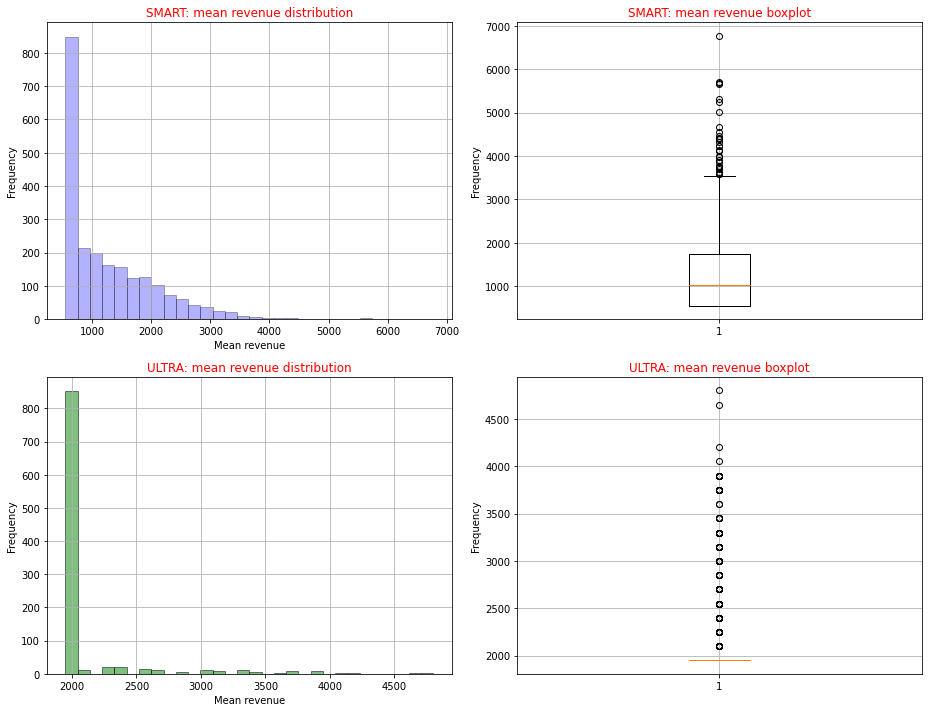

In [36]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize=(13, 10))
axes[0,0].set_title('SMART: mean revenue distribution', color='red')
axes[0,0].hist(revenue.query('tariff == "smart"')['total_rev'], bins=30, alpha=0.3, ec='black', color='blue')
axes[0,0].grid()
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xlabel('Mean revenue')


axes[0,1].set_title('SMART: mean revenue boxplot', color='red')
axes[0,1].boxplot(revenue.query('tariff == "smart"')['total_rev'])
axes[0,1].grid()
axes[0,1].set_ylabel('Frequency')

axes[1,0].set_title('ULTRA: mean revenue distribution', color='red')
axes[1,0].hist(revenue.query('tariff == "ultra"')['total_rev'], bins=30, alpha=0.5, ec='black', color='green')
axes[1,0].grid()
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_xlabel('Mean revenue')

axes[1,1].set_title('ULTRA: mean revenue boxplot', color='red')
axes[1,1].boxplot(revenue.query('tariff == "ultra"')['total_rev'])
axes[1,1].grid()
axes[1,1].set_ylabel('Frequency')

fig.tight_layout();

Распределения обеих выборок (выручка пользователей на тарифе SMART и на тарифе ULTRA) не похожи на нормальные - они сильно скошены к значениям, близким к размеру абонентской платы (мы помним, что ранее для тарифа ULTRA мы получили крайне малую долю клиентов, кто хотя бы раз за год выходил за границы лимита, включенного в абонентскую плату). Boxplot в обоих случаях показывает наличие выбросов - экстремально больших значений выручки.

Применение некоторых статистических тестов, в частности, t-теста Стьюдента, требует соблюдения условия о нормальности распределения и гомоскедастичности (однородности) дисперсии. Поскольку у нас есть серьезные подозрения относительно нормального распределения наших выборок, применим тест Шапиро-Уилка.

In [37]:
stat, p = scipy.stats.shapiro(revenue.query('tariff == "smart"')['total_rev']) 
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.843, p-value=0.000
Отклонить гипотезу о нормальности


Тест Шапиро-Уилка при установленном уровне значимости 5% позволяет нам отклонить гипотезу о нормальности распределения средних значений выручки пользователей тарифа SMART. Наглядно результат можно продемонстрировать при помощи графика Q-Q plot

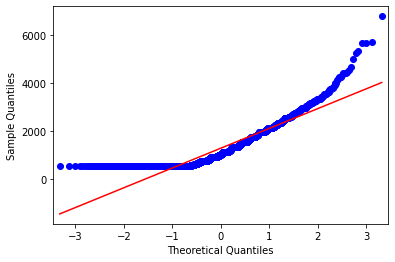

In [38]:
sm.qqplot(revenue.query('tariff == "smart"')['total_rev'], line='s');

На графике синими точками отмечено распределение данных нашей выборки, красной линией обозначены теоретические значения, если бы наш признак был распределен нормальным образом. Мы видим cущественные отклонения в нижней и верхней частях реального графика. Точки, лежащие над прямой теоретического нормального распределения обозначают, что мы получаем слишком большие значения, чем могли бы получить в случае если бы значения были распределены нормальным образом.

Проделаем аналогичные действия с выборкой значений выручки для клиентов с тарифом ULTRA

In [39]:
stat, p = scipy.stats.shapiro(revenue.query('tariff == "ultra"')['total_rev']) 
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.367, p-value=0.000
Отклонить гипотезу о нормальности


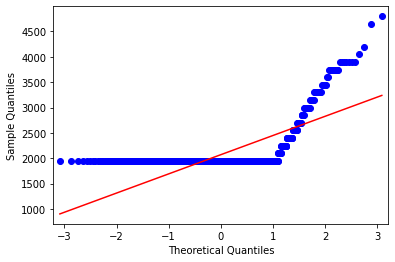

In [40]:
sm.qqplot(revenue.query('tariff == "ultra"')['total_rev'], line='s');

Мы отклонили нулевую гипотезу о нормальном распределении значений средней выручки для пользователей тарифа ULTRA. График "квантиль-квантиль" демонтрирует имеющиеся в нашей выборке отклонения от теоретических нормальных значений. В нашей выборке избыток слишком больших и слишком малых значений и недостаток средних.

Итак, наши 2 выборки имеют распределение, отличное от нормального. Присутствуют выбросы, дисперсии не равны. Применять в данном случает t-test Стьюдента - значит увеличить вероятность ошибки первого рода (отклонение нулевой гипотезы и принятие альтернативной, в то время как на самом деле верна нулевая). Отсекать выбросы только для того, чтобы применить тот или иной тест - не лучшее решение. Для финансовых данных (таких как размер выручки) считаем разумным применение непараметрического рангового u-критерия Манна-Уитни, который отлично работает в случаях, подобных нашему (и не чувствителен к выбросам).

### Выручка в разрезе городов (Москва / регионы)

Исследуем значения среднемесячной выручки в зависимости от региона проживания абонента (есть предположение, что жители столицы тратят на связь больше, чем жители других регионов страны).

Для удобства группировки по признаку Москва / регионы добавим в датафрейм revenue столбец `city_mark`, в котором Москве будет соответствовать 1, а другим регионам - 0. Рассчитаем показатели среднего, дисперсии и стандартного отклонения выручки для каждой группы

In [41]:
revenue['city_mark'] = revenue['city'].where(revenue['city'] == 'Москва', 0)
revenue['city_mark'] = revenue['city_mark'].where(revenue['city_mark'] == 0, 1)
revenue['city_mark'].value_counts()

revenue.groupby('city_mark')['total_rev'].agg(['mean', 'var', 'std']).round(0)

0    2605
1     611
Name: city_mark, dtype: int64

,mean,var,std
city_mark,,,
0,1528.0,656698.0,810.0
1,1551.0,566183.0,752.0


У нас получились 2 неравные по размеру выборки: группа "москвичей" (611 наблюдений) и "не-москвичей" (2605 наблюдений). Средние значения выручки практически равны, дисперсия и стандартное отклонение различаются незначительно. Посмотрим, как распределены значения на графиках

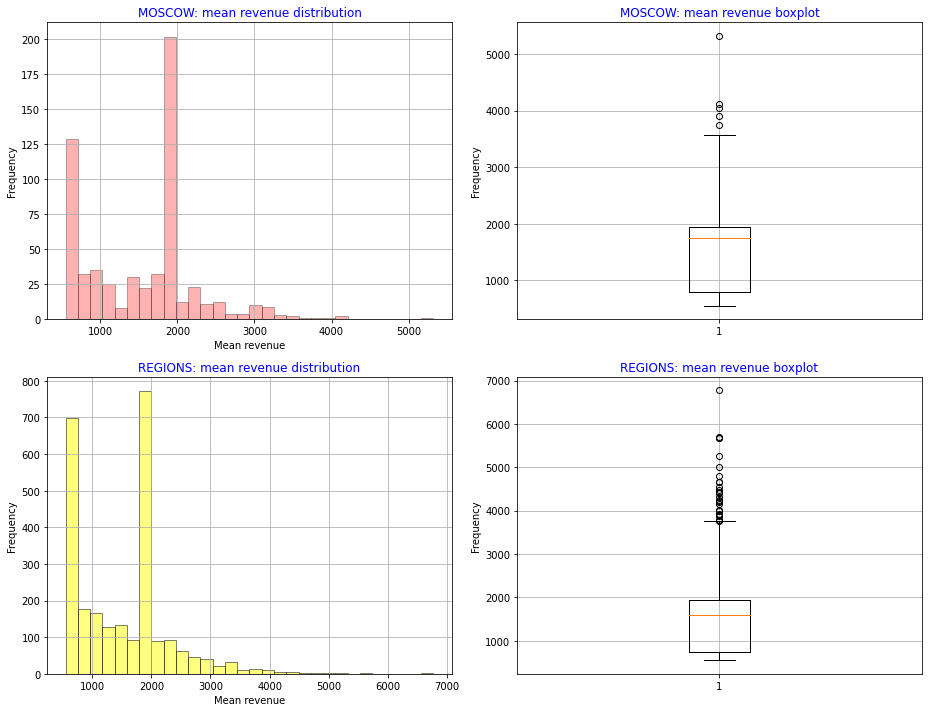

In [42]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize=(13, 10))
axes[0,0].set_title('MOSCOW: mean revenue distribution', color='blue')
axes[0,0].hist(revenue.query('city_mark == 1')['total_rev'], bins=30, alpha=0.3, ec='black', color='red')
axes[0,0].grid()
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xlabel('Mean revenue')

axes[0,1].set_title('MOSCOW: mean revenue boxplot', color='blue')
axes[0,1].boxplot(revenue.query('city_mark == 1')['total_rev'])
axes[0,1].grid()
axes[0,1].set_ylabel('Frequency')

axes[1,0].set_title('REGIONS: mean revenue distribution', color='blue')
axes[1,0].hist(revenue.query('city_mark == 0')['total_rev'], bins=30, alpha=0.5, ec='black', color='yellow')
axes[1,0].grid()
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_xlabel('Mean revenue')

axes[1,1].set_title('REGIONS: mean revenue boxplot', color='blue')
axes[1,1].boxplot(revenue.query('city_mark == 0')['total_rev'])
axes[1,1].grid()
axes[1,1].set_ylabel('Frequency')

fig.tight_layout();

Распределения значений средней выручки по регионам похожи на бимодальные (тогда как нормальное распределение должно быть унимодально). На гистограммах отчетливо видны пики на значениях в районе 500 и 2000 - то есть около значений, равных абоненской плате. 

Боксплоты показывают наличие выбросов в виде экстремально больших значений.
Если наше предположение о ненормальности распределения выборок верны, мы выберем критерий Манна-Уитни для проверки нашей гипотезы.

Применим тест Шапиро-Уилка для проверки распределений на нормальность.

In [43]:
stat, p = scipy.stats.shapiro(revenue.query('city_mark == 1')['total_rev']) 
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')
    

stat, p = scipy.stats.shapiro(revenue.query('city_mark == 0')['total_rev']) 
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.901, p-value=0.000
Отклонить гипотезу о нормальности
Statistics=0.895, p-value=0.000
Отклонить гипотезу о нормальности


Гипотеза подтвердилась - данные в обеих выборках не распределены нормально. Плюс имеются выбросы, которые могут значительно исказить результаты t-теста Стьюдента. 

Таким образом, в данном разделе мы подробно исседовали значения среднемесячной выручки на клиента в разрезе групп Москва / регионы. Значения в выборках не распределены нормальным образом, присутствуют выбросы в виде максимальных значений, распределения имеют явный скос в сторону меньших значений. Все эти факторы дают нам основания отказаться от применения t-теста Стьюдента в пользу его альтернативы - теста Манна-Уитни.

Перейдем к проверке гипотез

### Формулирование и проверка гипотез

**Гипотеза 1: Средняя выручка пользователей на тарифах SMART и ULTRA различается**

***

В нашей выборке из 500 пользователей средняя выручка на тарифе ULTRA почти в 2 раза превышает аналогичный показатель для тарифа SMART. Но что если такое значение получено случайно, и в генеральной совокупности выручка пользователей двух тарифов не различается?

Для проверки этой гипотезы мы будем использовать односторонний тест Манна-Уитни с уровнем значимости альфа равным 0.05.

Сформулируем нулевую и альтернативную гипотезы.

***H0***: в общей массе клиентов выручка на тарифе ULTRA меньше или равна выручке на тарифе SMART.  
***H1***: среднемесячная выручка на тарифе ULTRA по всем клиентам выше, чем среднемесячная выручка на тарифе SMART.

In [44]:
stat, p = mannwhitneyu(
    revenue.query('tariff == "ultra"')['total_rev'], 
    revenue.query('tariff == "smart"')['total_rev'],
    alternative='greater'
)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if (p < alpha) and (
    revenue.query('tariff == "ultra"')['total_rev'].mean() > revenue.query('tariff == "smart"')['total_rev'].mean()
    ):
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований для отклонения нулевой гипотезы')

Statistics=1795700.500, p=0.000
Отклоняем нулевую гипотезу


В результате теста мы получили p-уровень значимости почти равный нулю при уровне значимости альфа 5%. Мы можем сделать вывод о том, что с достоверностью 95% вероятность того, что мы ошибаемся, отклоняя нулевую гипотезу и принимая альтернативную, практически равно нулю.
Напомню, что альтернативная гипотеза предполагает, что выручка на тарифе ULTRA выше, чем на SMARТ.

***

**Гипотеза 2: средняя выручка клиентов из Москвы отличается от средней выручки клиентов из других регионов**.

Применим двусторонний тест Манна-Уитни, уровень значимости установим 0.05.

***Н0 (нулевая гипотеза)***: значение средней выручки клиентов из Москвы в генеральной совокупности равно значению средней выручки клиентов из других регионов, а любые отличия получены случайным образом. 

***H1 (альтернативная гипотеза)***: значение средней выручки клиентов из Москвы больше или меньше значения выручки для клиентов из других регионов. 

In [45]:
stat, p = mannwhitneyu(
    revenue.query('city == "Москва"')['total_rev'], 
    revenue.query('city != "Москва"')['total_rev'],
    alternative='two-sided'
)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нет оснований для отклонения нулевой гипотезы')
else:
    print('Отклоняем нулевую гипотезу')

Statistics=813683.000, p=0.381
Нет оснований для отклонения нулевой гипотезы


Тест показал, что наши данные не дают нам достаточных оснований отклонить нулевую гипотезу. Значит средняя выручка в генеральной совокупности одинакова как для москвичей, так и для клиентов из других регионов России, а любые различия, полученные в выборке, носят случайный характер.

## Общий вывод

Мы проанализировали статистику по звонкам, смс и мобильному трафику для выборки из 500 клиентов мобильного оператора "Мегалайн" за период 01.01.2018-31.12.2018. Клиенты использовали один из двух тарифов - SMART или ULTRA - с различным объемом входящих в абонентскую плату услуг и различной стоимостью услуг сверх лимита.

Клиенты, пользующиеся тарифом SMART, в 95% случаев хотя бы раз в год выходили за пределы "бесплатного пакета" и были вынуждены доплачивать за каждую лишнюю минуту разговора, сообщение или гигабайт трафика. Таким образом, среднемесячная выручка по ним в 2.5 раза превысила размер абонентской платы на данном тарифе.

В то же время клиенты на тарифе ULTRA по звонкам и смс чаще всего укладывались в предоставленные им лимиты, доплачивая только за интернет. Вследствие этого среднемесячный размер выручки с этих клиентов незначительно превышает размер абоненской платы, то есть у мобильного оператора ограничена возможность увеличить среднюю сумму чека.

В процессе исследования мы проверили и подтвердили гипотезу о том, что среднемесячная выручка с клиента в генеральной совокупности (в совокупности всех клиентов компании, использующих данные тарифы) различается для тарифов SMART и ULTRA. Данные нашей выборки с достоверностью 95% не противоречат гипотезе о том, что тариф ULTRA приносит компании больше денег.
Эти результаты можно использовать в качестве руководства к действию для отдела продаж.

Вторая гипотеза предполагала, что абоненты в Москве склонны тратить больше денег на услуги связи, чем в регионах, а значит приносить компании больший доход. Однако исследование не подтвердило это предположение: базируясь на имеющейся выборке, мы не нашли достаточных оснований полагать, что значение средней выручки для клиентов из Москвы и регионов различается. Данный вывод может помочь компании при планировании расширения географии и развития сети региональных офисов продаж, однако для принятия более взвешенного решения по тому или иному региону рекомендуем исследовать также другие факторы, влияющие на выбор клиентом тарифа или оператора связи (доход на душу населения, покупательная способность, зоны покрытия сотовых операторов, предложения конкурентов и пр.). Коммерческому отделу при принятии решения о распределении бюджета на рекламу по регионам следует принять во внимание сделанные нами выводы, и опираться больше на показатели затрат на рекламу в том или ином регионе, нежели чем на планируемую выручку. 

При анализе объема потребления клиентами услуг компании были отмечены некоторые аномалии в поведении абонентов тарифа ULTRA (резкое снижение объема в феврале 2018 года). Рекомендуем провести детальный анализ сезонности на основе большей выборки данных, охватывающей период в несколько лет.

В данном исследовании нами намеренно были исключены эпизоды, в которых длительность разговора и количество мб трафика было равно нулю (мы предположили, что это факты неотвеченных вызовов и неуспешного подключения к интернету). Такие случаи не тарифицируются оператором и не оказывают влияние на расчет выручки. Однако, эти данные могут быть полезны при расчете других финансовых показателей, поскольку они могут влиять на себестоимость услуг в том случае, если оператор несет расходы на организацию соединения даже в том случае, если оно было в итоге неуспешным.

Поскольку неуспешные звонки клиентов нашей выборки составляют 20% от общего количества совершенных ими звонков, а неуспешные сессии - 13%, эта информация может быть использована отделом развития для повышения качества услуг компании или разработки новых продуктов, который позволят сгладить негативный опыт клиента и повысить общий доход компании.